# Contributors
Zijian Zhang 14851598 $\\$
Amish Sewlal 13297503 $\\$
Ravi Sharma Kaushik 14332744

# Imports

In [2]:
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from Mandelbrot import *
from MonteCarloIntegration import *
from ColorfulMandelbrotSet import mandelbrot_Set_Image
from QuasiMonteCarlo import *

# Number of simulations used for every comparison
N = 100

# Creating Mandlebrot Set

C:\Users\damia\Desktop\School\CLS\Stochastic Simulation\Assignments\ColorfulMandelbrotSet.py:25: RuntimeWarning: overflow encountered in square
  Z = Z ** 2 + C
C:\Users\damia\Desktop\School\CLS\Stochastic Simulation\Assignments\ColorfulMandelbrotSet.py:25: RuntimeWarning: invalid value encountered in square
  Z = Z ** 2 + C


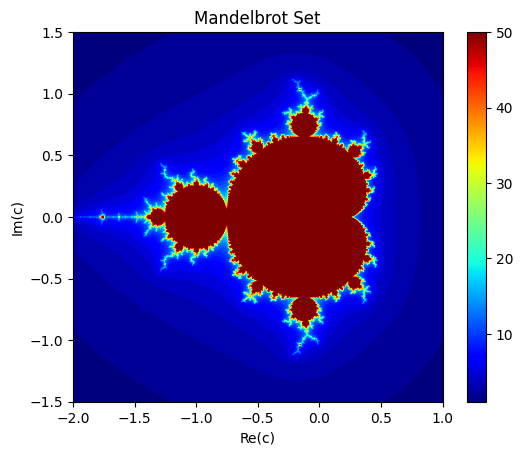

<Figure size 640x480 with 0 Axes>

In [42]:
from ColorfulMandelbrotSet import mandelbrot_Set_Image
mandelbrot_Set_Image(-2, 1, -1.5, 1.5, 3000, 3000, 50)

plt.savefig('results/Mandelbrot.png', dpi=300)

# Area of Mandlebrot Set using Monte Carlo Method

In [6]:
low = -2
high = 2
sample = 100**2
iterations = 500
areas = []
for _ in range(N):
    A = randomSampling(low, high, iterations, sample)
    areas.append(A)

A_mean = np.mean(areas)
A_conf = np.std(areas, ddof=1) * 1.96 / np.sqrt(N)
print(f'A = {A_mean} +- {A_conf}')

A = 1.5175200000000004 +- 0.008958249404742855


# Convergence study for various number of iterations

In [159]:
low = -2
high = 2
sample = 100**2
iterations = np.arange(10, 500, 5)

# Array to save results
var_iters = []

# Looping through each iteration
for iteration in iterations:
    # Saving each obtained area
    area = []
    # Looping through simulations
    for _ in range(N):
        A = randomSampling(low, high, iteration, sample)
        area.append(A)

    # Add to results
    var_iters.append(area)

# Save results
results = np.insert(var_iters, 0, iterations, axis=1)
np.savetxt('results/RS_vary_iters.txt', results)

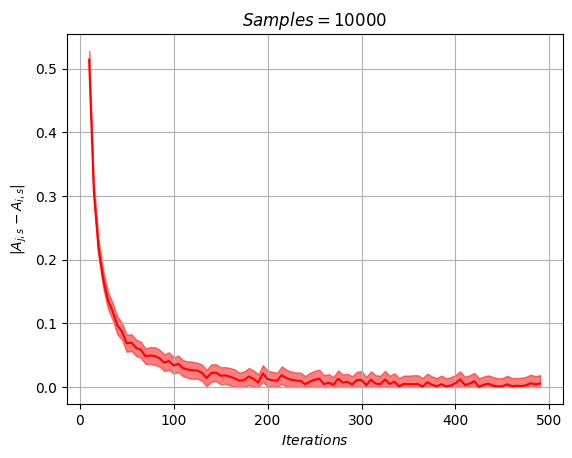

In [19]:
# Load from results
results = np.loadtxt('results/RS_vary_iters.txt')
iterations = results[:, 0]
var_iters = results[:, 1:]

sample = 100**2

# Getting mean and std at each iteration number
A_mean = np.mean(var_iters, axis=1)
A_std = np.std(var_iters, ddof=1, axis=1)

# Getting difference in area and confidence interval
dA = abs(A_mean[:-1] - A_mean[-1])
dA_conf = (A_std[:-1] ** 2 + A_std[-1] ** 2)**0.5 * 1.96 / N**0.5

# Getting left and right interval
left = dA - dA_conf
right = dA + dA_conf
left[left < 0] = 0

# Plotting
plt.plot(iterations[:-1], dA, color='red')
plt.fill_between(iterations[:-1], left, right, color='red', alpha=0.5)

# Plot settings
plt.xlabel('$Iterations$')
plt.ylabel('$|A_{j,s} - A_{i,s}|$')
plt.title(f'$Samples = {sample}$')
plt.grid()

# Save figure
plt.savefig('results/RS_vary_iters.png', dpi=300)


In [59]:
a = 1 - 0.95

# Looping through iterations and areas
for iteration, areas in zip(iterations, var_iters):
    # Perform Welch-test
    welch = ttest_ind(areas, var_iters[-1], equal_var=False)
    p = welch.pvalue
    if p > a:
        print(f'Convergence at {iteration} iterations, p = {p}')
        break


Convergence at 165.0 iterations, p = 0.058457081462447255


# Convergence study for various number of samples

In [162]:
low = -2
high = 2
iteration = 500
samples = np.arange(6, 100, 2)**2

# Array to save results
var_samples = []

# Looping through each iteration
for sample in samples:
    # Saving each obtained area
    area = []
    # Looping through simulations
    for _ in range(N):
        A = randomSampling(low, high, iteration, sample)
        area.append(A)

    # Add to results
    var_samples.append(area)

# Save results
results = np.insert(var_samples, 0, samples, axis=1)
np.savetxt('results/RS_vary_samples.txt', results)

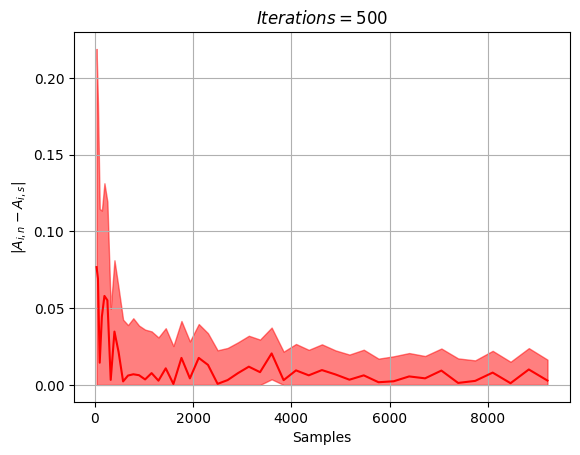

In [18]:
# Load from results
results = np.loadtxt('results/RS_vary_samples.txt')
samples = results[:, 0]
var_samples = results[:, 1:]

iteration = 500

# Getting mean and std at each iteration number
A_mean = np.mean(var_samples, axis=1)
A_std = np.std(var_samples, ddof=1, axis=1)

# Getting difference in area and confidence interval
dA = abs(A_mean[:-1] - A_mean[-1])
dA_conf = (A_std[:-1] ** 2 + A_std[-1] ** 2)**0.5 * 1.96 / N**0.5

# Getting left and right interval
left = dA - dA_conf
right = dA + dA_conf
left[left < 0] = 0

# Plotting
plt.plot(samples[:-1], dA, color='red')
plt.fill_between(samples[:-1], left, right, color='red', alpha=0.5)

# Plot settings
plt.xlabel('Samples')
plt.ylabel('$|A_{i, n} - A_{i,s}|$')
plt.title(f'$Iterations = {iteration}$')
plt.grid()

# Save figure
plt.savefig('results/RS_vary_samples.png', dpi=300)


In [62]:
a = 1 - 0.95

# Looping through iterations and areas
for sample, areas in zip(samples, var_samples):
    # Perform welch test to test means
    welch = ttest_ind(areas, var_samples[-1], equal_var=False)
    
    # Get p value
    p = welch.pvalue
    
    # When means are not significant different
    if p > a:
        print(f'Convergence at {sample} samples, p = {p}')
        break


Convergence at 36.0 samples, p = 0.2924831979423463


# Convergence with varying iterations for different sampling techniques

In [165]:
low = -2
high = 2
sample = 100**2
iterations = np.arange(10, 500, 5)

# Array to save results
var_iters2 = [[], []]

# Looping through each iteration
for iteration in iterations:
    # Saving each obtained area
    area_LHS = []
    area_orth = []
    # Looping through simulations
    for _ in range(N):
        # Latin Hypercube
        A = latinHypercubeSampling(low, high, iteration, sample)
        area_LHS.append(A)
        
        # Orthogonal sampling
        A = orthogonalSampling(low, high, iteration, sample)
        area_orth.append(A)
        

    # Add to results
    var_iters2[0].append(area_LHS)
    var_iters2[1].append(area_orth)

# Names
names = ['LHS', 'Orthogonal']

# Saving results
for res, name in zip(var_iters2, names):
    results = np.insert(res, 0, iterations, axis=1)
    np.savetxt(f'results/{name}_vary_iters.txt', results)

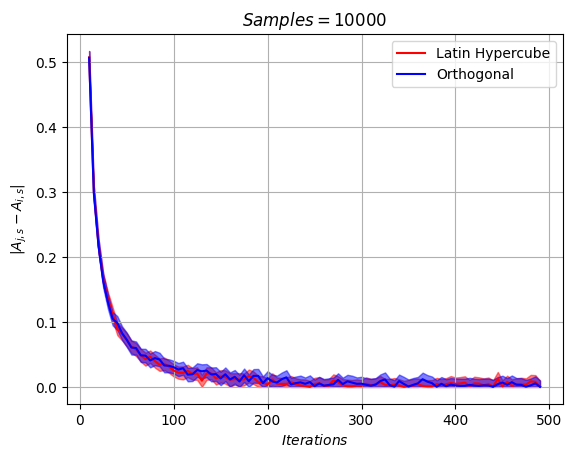

In [17]:
# Colors used and their respective label names
colors = ['red', 'blue']
labels = ['Latin Hypercube', 'Orthogonal']

# Number of samples used
sample = 100**2

# Names
names = ['LHS', 'Orthogonal']

# Loading data
var_iters2 = []
for name in names:
    results = np.loadtxt(f'results/{name}_vary_iters.txt')
    var_iters2.append(results[:, 1:])
    iterations = results[:, 0]

# Looping through sampling techniques
for i, areas in enumerate(var_iters2):    
    A_mean = np.mean(areas, axis=1)
    A_std = np.std(areas, ddof=1, axis=1)

    # Getting difference in area and confidence interval for LHS
    dA = abs(A_mean[:-1] - A_mean[-1])
    dA_conf = (A_std[:-1] ** 2 + A_std[-1] ** 2)**0.5 * 1.96 / N**0.5

    # Getting left and right interval
    left = dA - dA_conf
    right = dA + dA_conf
    left[left < 0] = 0

    # Plotting
    plt.plot(iterations[:-1], dA, color=colors[i], label=labels[i])
    plt.fill_between(iterations[:-1], left, right, color=colors[i], alpha=0.5)

# Plot settings
plt.xlabel('$Iterations$')
plt.ylabel('$|A_{j,s} - A_{i,s}|$')
plt.title(f'$Samples = {sample}$')
plt.legend()
plt.grid()

# Save figure
plt.savefig('results/LSH_Orthogonal_vary_iters.png', dpi=300)


In [64]:
a = 1 - 0.95

# Looping through both sample techniques
for i, sampling in enumerate(var_iters2):
    for iteration, areas in zip(iterations, sampling):
        # Perform welch test to test means
        welch = ttest_ind(areas, var_iters[-1], equal_var=False)
    
        # Get p value
        p = welch.pvalue
    
        # When means are not significant different
        if p > a:
            print(f'Convergence for {labels[i]} at {iteration} iterations, p = {p}')
            break

Convergence for Latin Hypercube at 200.0 iterations, p = 0.15808840087231726
Convergence for Orthogonal at 170.0 iterations, p = 0.05283378024063678


# Convergence with varying samples for different sampling techniques

In [172]:
low = -2
high = 2
iteration = 500
samples = np.arange(6, 100, 2)**2

# Array to save results
var_samples2 = [[], []]

# Looping through each iteration
for sample in samples:
    # Saving each obtained area
    area_LHS = []
    area_orth = []
    # Looping through simulations
    for _ in range(N):
        # Latin Hypercube
        A = latinHypercubeSampling(low, high, iteration, sample)
        area_LHS.append(A)

        # Orthogonal sampling
        A = orthogonalSampling(low, high, iteration, sample)
        area_orth.append(A)


    # Add to results
    var_samples2[0].append(area_LHS)
    var_samples2[1].append(area_orth)

# Names
names = ['LHS', 'Orthogonal']


# Saving results
for res, name in zip(var_samples2, names):
    results = np.insert(res, 0, samples, axis=1)
    np.savetxt(f'results/{name}_vary_samples.txt', results)

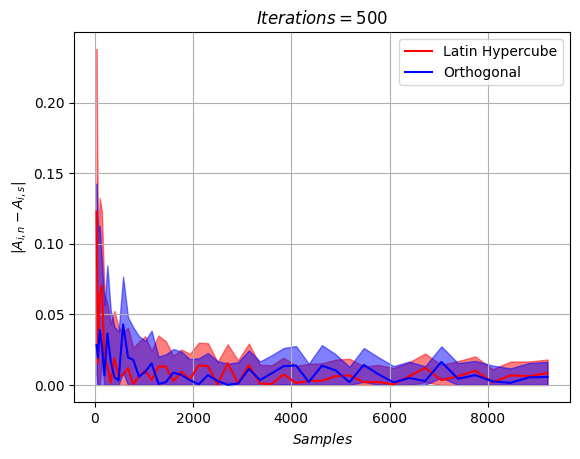

In [16]:
# Names
names = ['LHS', 'Orthogonal']

# Colors used and their respective label names
colors = ['red', 'blue']
labels = ['Latin Hypercube', 'Orthogonal']

iteration = 500

# Loading data
var_samples2 = []
for name in names:
    results = np.loadtxt(f'results/{name}_vary_samples.txt')
    var_samples2.append(results[:, 1:])
    samples = results[:, 0]

# Looping through sampling techniques
for i, areas in enumerate(var_samples2):
    A_mean = np.mean(areas, axis=1)
    A_std = np.std(areas, ddof=1, axis=1)

    # Getting difference in area and confidence interval for LHS
    dA = abs(A_mean[:-1] - A_mean[-1])
    dA_conf = (A_std[:-1] ** 2 + A_std[-1] ** 2)**0.5 * 1.96 / N**0.5

    # Getting left and right interval
    left = dA - dA_conf
    right = dA + dA_conf
    left[left < 0] = 0

    # Plotting
    plt.plot(samples[:-1], dA, color=colors[i], label=labels[i])
    plt.fill_between(samples[:-1], left, right, color=colors[i], alpha=0.5)

# Plot settings
plt.xlabel('$Samples$')
plt.ylabel('$|A_{i, n} - A_{i,s}|$')
plt.title(f'$Iterations = {iteration}$')
plt.legend()
plt.grid()

# Save figure
plt.savefig('results/LSH_Orthogonal_vary_samples.png', dpi=300)


In [77]:
a = 1 - 0.95

# Looping through both sample techniques
for i, sampling in enumerate(var_samples2):
    for sample, areas in zip(samples, sampling):
        # Perform welch test to test means
        welch = ttest_ind(areas, sampling[-1], equal_var=False)

        # Get p value
        p = welch.pvalue

        # When means are not significant different
        if p > a:
            print(f'Convergence for {labels[i]} at {sample} samples, p = {p}')
            break

Convergence for Latin Hypercube at 64.0 samples, p = 0.7183005501856512
Convergence for Orthogonal at 36.0 samples, p = 0.6294164791313759


In [74]:
samples = [100**2] * 3
iterations = [500] * 3
funcs = [randomSampling, latinHypercubeSampling, orthogonalSampling]
names = ['Random Sampling', 'Latin Hypercube Sampling', 'Orthogonal Sampling']
areas = [[], [], []]

# Parameters
low = -2
high = 2

# Looping through each simulation
for _ in range(N):
    # Looping through each sampling technique
    for i in range(3):
        A = funcs[i](low, high, samples[i], iterations[i])
        areas[i].append(A)

# Getting mean and confidence interval
A = np.mean(areas, axis=1)
conf = np.std(areas, ddof=1, axis=1) * 1.96 / N**0.5

# Printing results
for i in range(3):
    print(f'{names[i]}: {A[i]:.3f} +- {conf[i]:.3f}')

    

KeyboardInterrupt: 

# Approach for improving convergence

In [4]:
low = -2
high = 2
sample = 100**2
iterations = np.arange(10, 500, 5)

# Array to save results
var_iters3 = []

# Looping through each iteration
for iteration in iterations:
    # Saving each obtained area
    area = []
    # Looping through simulations
    for _ in range(N):
        A = quasiMC(low, high, iteration, sample)
        area.append(A)

    # Add to results
    var_iters3.append(area)

# Save results
results = np.insert(var_iters3, 0, iterations, axis=1)
np.savetxt('results/QMC_vary_iters.txt', results)

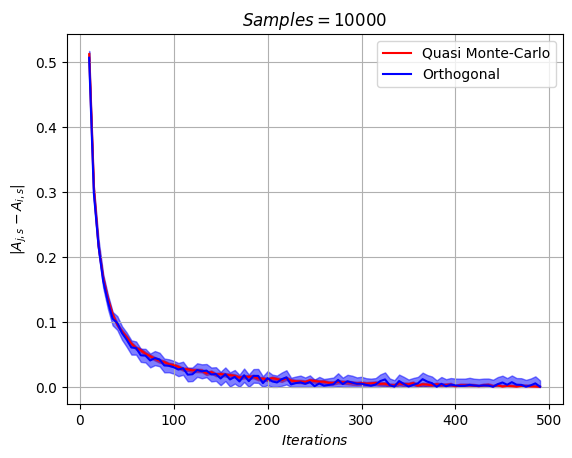

In [15]:
# Load from results
results = np.loadtxt('results/QMC_vary_iters.txt')
iterations = results[:, 0]
var_iters3 = results[:, 1:]

sample = 100**2

# Getting mean and std at each iteration number
A_mean = np.mean(var_iters3, axis=1)
A_std = np.std(var_iters3, ddof=1, 
               axis=1)


# Getting difference in area and confidence interval
dA = abs(A_mean[:-1] - A_mean[-1])
dA_conf = (A_std[:-1] ** 2 + A_std[-1] ** 2)**0.5 * 1.96 / N**0.5
# Getting left and right interval
left = dA - dA_conf
right = dA + dA_conf
left[left < 0] = 0

# Plotting
plt.plot(iterations[:-1], dA, color='red', label='Quasi Monte-Carlo')
plt.fill_between(iterations[:-1], left, right, color='red', alpha=0.5)

# Getting mean and std at each iteration number
A_mean = np.mean(var_iters2[1], axis=1)
A_std = np.std(var_iters2[1], ddof=1,
               axis=1)


# Getting difference in area and confidence interval
dA = abs(A_mean[:-1] - A_mean[-1])
dA_conf = (A_std[:-1] ** 2 + A_std[-1] ** 2)**0.5 * 1.96 / N**0.5
# Getting left and right interval
left = dA - dA_conf
right = dA + dA_conf
left[left < 0] = 0

# Plotting
plt.plot(iterations[:-1], dA, color='blue', label='Orthogonal')
plt.fill_between(iterations[:-1], left, right, color='blue', alpha=0.5)

# Plot settings
plt.xlabel('$Iterations$')
plt.ylabel('$|A_{j,s} - A_{i,s}|$')
plt.title(f'$Samples = {sample}$')
plt.legend()
plt.grid()

# Save figure
plt.savefig('results/QMC_vary_iters.png', dpi=300)


In [6]:
a = 1 - 0.95

# Looping through iterations and areas
for iteration, areas in zip(iterations, var_iters3):
    # Perform Welch-test
    welch = ttest_ind(areas, var_iters3[-1], equal_var=False)
    p = welch.pvalue
    if p > a:
        print(f'Convergence at {iteration} iterations, p = {p}')
        break


Convergence at 330.0 iterations, p = 0.057483566469378466


In [7]:
low = -2
high = 2
iteration = 500
samples = np.arange(6, 100, 2)**2

# Array to save results
var_samples3 = []

# Looping through each iteration
for sample in samples:
    # Saving each obtained area
    area = []
    # Looping through simulations
    for _ in range(N):
        A = quasiMC(low, high, iteration, sample)
        area.append(A)

    # Add to results
    var_samples3.append(area)

# Save results
results = np.insert(var_samples3, 0, samples, axis=1)
np.savetxt('results/QMC_vary_samples.txt', results)

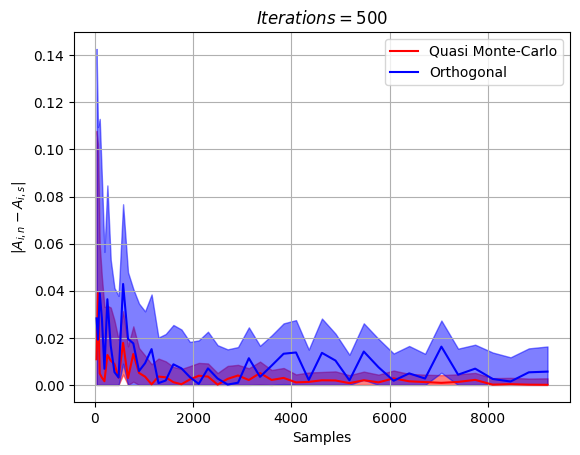

In [14]:
# Load from results
results = np.loadtxt('results/QMC_vary_samples.txt')
samples = results[:, 0]
var_samples3 = results[:, 1:]

iteration = 500

# Getting mean and std at each iteration number
A_mean = np.mean(var_samples3, axis=1)
A_std = np.std(var_samples3, ddof=1, axis=1)

# Getting difference in area and confidence interval
dA = abs(A_mean[:-1] - A_mean[-1])
dA_conf = (A_std[:-1] ** 2 + A_std[-1] ** 2)**0.5 * 1.96 / N**0.5

# Getting left and right interval
left = dA - dA_conf
right = dA + dA_conf
left[left < 0] = 0

# Plotting
plt.plot(samples[:-1], dA, color='red', label='Quasi Monte-Carlo')
plt.fill_between(samples[:-1], left, right, color='red', alpha=0.5)

# Getting mean and std at each iteration number
A_mean = np.mean(var_samples2[1], axis=1)
A_std = np.std(var_samples2[1], ddof=1, axis=1)

# Getting difference in area and confidence interval
dA = abs(A_mean[:-1] - A_mean[-1])
dA_conf = (A_std[:-1] ** 2 + A_std[-1] ** 2)**0.5 * 1.96 / N**0.5

# Getting left and right interval
left = dA - dA_conf
right = dA + dA_conf
left[left < 0] = 0

plt.plot(samples[:-1], dA, color='blue', label='Orthogonal')
plt.fill_between(samples[:-1], left, right, color='blue', alpha=0.5)

# Plot settings
plt.xlabel('Samples')
plt.ylabel('$|A_{i,n} - A_{i,s}|$')
plt.title(f'$Iterations = {iteration}$')
plt.legend()
plt.grid()

# Save figure
plt.savefig('results/QMC_vary_samples.png', dpi=300)


In [9]:
a = 1 - 0.95

# Looping through iterations and areas
for sample, areas in zip(samples, var_samples3):
    # Perform welch test to test means
    welch = ttest_ind(areas, var_samples3[-1], equal_var=False)

    # Get p value
    p = welch.pvalue

    # When means are not significant different
    if p > a:
        print(f'Convergence at {sample} samples, p = {p}')
        break

Convergence at 36.0 samples, p = 0.8258651146411055
